In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker
import requests
from sklearn.metrics import r2_score
import catboost
import re

In [2]:
def get_covid_data(info='cases'):
    if info == 'cases':
        url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
               'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').format(sep=2*'\n')
        ren_col = 'Total_cases'
        val_col = 'Daily_cases'
    if info =='deaths':
            url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                    'csse_covid_19_time_series/time_series_covid19_deaths_US.csv').format(sep=2*'\n')
            ren_col = 'Total_deaths'
            val_col = 'Daily_deaths'
    df = pd.read_csv(url)
    df = df[df['iso3']=='USA']
    df = df.dropna(subset = ['FIPS'])
    df = df[df.FIPS <= 56045]

    df.FIPS = df.FIPS.astype(int).astype(str).str.zfill(5)
    df = df[(df.Admin2 != 'Unassigned' ) & (df.Admin2.notna() )]
    df = df.drop(columns= ['UID','iso2', 'iso3', 'code3','Country_Region','Combined_Key' ])
    date_cols = [col for col in df.columns if '/20' in col]
    id_cols = [col for col in df.columns if col not in date_cols]
    df_gr = df.melt(id_vars=id_cols,value_vars=date_cols)
    df_gr[val_col] = df_gr.groupby(['FIPS'])[['value']].diff().fillna(0)
    df_gr = df_gr.rename(columns = {'value':ren_col, 'variable':'date', 
                                    'Long_':'Lng', 'Admin2':'COUNTY', 
                                   'Province_State': 'STATE', 'FIPS':'fips'})
    df_gr.date = pd.to_datetime( df_gr.date, infer_datetime_format=True)
    df_gr = df_gr.drop(columns = ['STATE', 'COUNTY'])
    return df_gr
    

In [3]:
def weekend(x):
    if x == 'Saturday' or x == 'Sunday':
        return 'Weekend'
    else:
        return 'Weekday'
    

def get_mobility_data(rolling_mean=False):
    mob_index_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
    
    df_mobility_index = pd.read_csv(mob_index_url, parse_dates=['date'])
    df_mobility_index = df_mobility_index.dropna(subset=['fips','admin2'])
    df_mobility_index.fips = df_mobility_index.fips.astype(int)
    df_mobility_index.fips = df_mobility_index.fips.astype(str).str.zfill(5)
    df_mobility_index = df_mobility_index.rename(columns={'admin1':'STATE','admin2':'COUNTY' })
    df_mobility_index = df_mobility_index.drop(columns = ['country_code', 'admin_level'])
    df_mobility_index['weekday'] = df_mobility_index.date.dt.day_name()
    df_mobility_index = df_mobility_index[df_mobility_index.m50<200]
    df_mobility_index['weekend'] = df_mobility_index['weekday'].apply(lambda x: weekend(x))

    if rolling_mean:
        mob_col= ['m50']
        m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
        m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
        m50 = m50.reset_index()
        return m50
    
    return df_mobility_index

In [4]:
df_mobility = get_mobility_data()
df_mobility_rm = get_mobility_data(rolling_mean=True)
df_mobility.sample(5)

,date,STATE,COUNTY,fips,samples,m50,m50_index,weekday,weekend
485783,2020-03-28,Virginia,Henrico County,51087,7719,0.872,10,Saturday,Weekend
86327,2020-04-22,Georgia,Murray County,13213,918,8.747,68,Wednesday,Weekday
464378,2020-09-09,Utah,Box Elder County,49003,1537,10.533,82,Wednesday,Weekday
365007,2020-06-28,Oklahoma,Le Flore County,40079,3207,6.980,76,Sunday,Weekend
101587,2020-06-05,Idaho,Owyhee County,16073,417,15.903,98,Friday,Weekday


In [5]:
# Importing County Level spending data from https://github.com/Opportunitylab/EconomicTracker

def get_spend_data():
    county_spending_url =  'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20County%20-%20Daily.csv'

    df_county_spending = pd.read_csv(county_spending_url,low_memory=False)

    df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                                df_county_spending['month'].astype(str) + '-' + \
                                df_county_spending['day'].astype(str)
    df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
    df_county_spending = df_county_spending.rename(columns={'countyfips':'fips'})
    print(df_county_spending.fips.nunique())
    df_county_spending.spend_all = df_county_spending.spend_all.str.replace('.','0.')
    df_county_spending.spend_all =df_county_spending.spend_all.astype(float)
    return df_county_spending

In [6]:
df_county_spending = get_spend_data()
df_county_spending

1672


,year,month,day,fips,spend_all,date
0,2020,1,6,01001,0.0000,2020-01-06
1,2020,1,6,01003,0.0000,2020-01-06
2,2020,1,6,01009,0.0000,2020-01-06
3,2020,1,6,01015,0.0000,2020-01-06
4,2020,1,6,01019,0.0000,2020-01-06
...,...,...,...,...,...,...
397931,2020,8,30,56035,-0.0148,2020-08-30
397932,2020,8,30,56037,0.0403,2020-08-30
397933,2020,8,30,56039,-0.1830,2020-08-30
397934,2020,8,30,56041,-0.1740,2020-08-30


In [7]:
def get_covid_rates():
    case_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Cases%20-%20County%20-%20Daily.csv?raw=true'
    death_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Deaths%20-%20County%20-%20Daily.csv?raw=true'
    df_covid_case_rate = pd.read_csv(case_url,low_memory=False)
    df_covid_death_rate = pd.read_csv(death_url,low_memory=False)
    df_covid_rate = pd.DataFrame()
    for df in [df_covid_case_rate,df_covid_death_rate]:
        df['date'] = df['year'].astype(str) + '-' + \
                            df['month'].astype(str) + '-' + \
                            df['day'].astype(str)
        df.date = pd.to_datetime(df.date, infer_datetime_format=True)
        df.countyfips = df.countyfips.astype(int)
        df.countyfips = df.countyfips.astype(str).str.zfill(5)
        df = df.rename(columns={'countyfips':'fips'})
        df = df.drop(columns=['month','day','year'])
        cols = list(df.columns[1:3])
        if 'death_rate' in cols:
            
            df = df.drop(columns=['fips','date'])
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0)
        df_covid_rate = pd.concat([df_covid_rate,df], axis =1)
    return df_covid_rate
    

In [8]:
df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['fips','date','Total_deaths','Daily_deaths']]
df_covid_merged = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['fips', 'date'])
df_covid_rate = get_covid_rates()
df_covid = pd.merge(left = df_covid_merged, right = df_covid_rate, on = ['fips', 'date'], how='outer')
df_covid = df_covid.dropna(subset=['Lat'])
df_covid

,fips,Lat,Lng,date,Total_cases,Daily_cases,Total_deaths,Daily_deaths,case_rate,new_case_rate,death_rate,new_death_rate
0,01001,32.539527,-86.644082,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01003,30.727750,-87.722071,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01005,31.868263,-85.387129,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01007,32.996421,-87.125115,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01009,33.982109,-86.567906,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
744649,56037,41.659439,-108.882788,2020-09-14,317.0,-1.0,2.0,0.0,NaN,NaN,NaN,NaN
744650,56039,43.935225,-110.589080,2020-09-14,476.0,6.0,1.0,0.0,NaN,NaN,NaN,NaN
744651,56041,41.287818,-110.547578,2020-09-14,312.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN
744652,56043,43.904516,-107.680187,2020-09-14,111.0,0.0,6.0,0.0,NaN,NaN,NaN,NaN


In [9]:
# Get API keys from config file
def get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY):
    
    url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'
    query = '?q=' + str(lat) + ','+str(lng)
    key = '&key=' + API_KEY
    ret_format = '&format=json'
    sdate = '&enddate='+ start_dt
    edate = '&date=' + end_dt
    tp = '&tp=24'
    final_url = url + query + ret_format +  edate + sdate + tp + key
    get_weather = requests.get(final_url)
    weather_data = json.loads(get_weather.text)
    return weather_data

def get_weather_data(lat,lng, start_date,end_date,fips,key_count):
    new_low = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    new_end = datetime.timedelta(days=34) + new_low
    final_end = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    df = pd.DataFrame()
    with open('./config/keys.json') as outfile:
        keys = json.load(outfile)
    API_KEYS = keys['weather_api_keys']
    last=False
    API_KEY=API_KEYS[key_count]
    if final_end-new_low <datetime.timedelta(days=34):
        weather_data = get_weather_chunk(lat,lng,start_date, end_date,API_KEY)
        while('error' in weather_data['data']):
                
                key_count+=1
                if key_count == len(API_KEYS):
                    raise Exception('Out of API Keys')
                API_KEY=API_KEYS[key_count]
                
                weather_data = get_weather_chunk(lat,lng,start_date, end_date,API_KEY)
        df = pd.DataFrame(weather_data['data']['weather'])
        last = True
    while(last==False):
        if new_end <final_end:
            
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            while('error' in weather_data['data']):            
                key_count+=1
                if key_count == len(API_KEYS):
                    raise Exception('Out of API Keys')
                API_KEY=API_KEYS[key_count]
                weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            new_low = new_end + datetime.timedelta(days=1)
            last_itr = new_end
            new_end = datetime.timedelta(days=34) + new_low

           
        else:
            new_low = last_itr + datetime.timedelta(days=1)
            new_end = final_end
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            last = True

    df = df.drop(columns=['uvIndex'])
    df_h = pd.DataFrame()
    
    for val in df['hourly'].values:
        df_h = pd.concat([df_h, pd.DataFrame(val)], ignore_index=True)
    
    df = pd.concat([df, df_h], axis=1)
    use_cols = ['date','tempC', 'maxtempC', 'mintempC','WindChillC','FeelsLikeC', 'visibilityMiles','HeatIndexC', 
            'avgtempC', 'windspeedMiles', 'winddirDegree','pressure', 'WindGustMiles','precipMM',
            'totalSnow_cm' , 'sunHour', 'DewPointC','humidity','uvIndex']
    df = df[use_cols]
    cols= [col for col in df.columns if col!='date']
    df= df.apply(pd.to_numeric, errors='ignore')
    df.date = pd.to_datetime(df.date, infer_datetime_format=True)
    df['fips'] = fips
    return df,key_count

In [10]:
start_date = datetime.datetime.strftime(df_covid.date.max(), '%Y-%m-%d')
end_date =  datetime.datetime.strftime(df_covid.date.min(), '%Y-%m-%d')
fips_lat_lng = df_covid[['fips','Lat','Lng']].drop_duplicates().dropna().set_index('fips').to_dict('index')  
fpath1 = './Data/Weather_Files/'
os.makedirs(fpath1, exist_ok=True)
files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
weather_files = [f for f in files_all if 'Weather' in f]
fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]
key_count = 0
for fips,lat_lng in list(fips_lat_lng.items()):
    if fips in fips_done:
        weather_df_fips = pd.read_csv(fpath1 + 'Weather_FIPS_'+str(fips)+'.csv',parse_dates=['date'])
        if weather_df_fips.date.max() >= df_covid.date.max():
            continue
        else:
            end_date = datetime.datetime.strftime(weather_df_fips.date.max()+datetime.timedelta(days=1),format='%Y-%m-%d') 
            start_date =datetime.datetime.strftime( df_covid.date.max(),format='%Y-%m-%d')     
    lat,lng = lat_lng['Lat'],lat_lng['Lng']
    weather_df,key_count = get_weather_data(lat,lng, start_date,end_date,fips,key_count)
    weather_df = pd.concat([weather_df_fips,weather_df], ignore_index=True, axis=0)
    weather_df.to_csv(fpath1 + 'Weather_FIPS_'+str(fips)+'.csv',index=False)

In [11]:
def get_weather(start_date):
    fpath = './Data/All_County_Weather_'+start_date+'.csv'
    if os.path.exists(fpath):
        df_weather = pd.read_csv(fpath, parse_dates=['date'])
    else:
        fpath1 = './Data/Weather_Files/'
        files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
        weather_files = [f for f in files_all if 'Weather' in f]
        fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]

        df_weather = pd.DataFrame()
        i=0
        for file in weather_files:
            df = pd.read_csv(file)
            df_weather = pd.concat([df_weather,df], ignore_index=True)
            i+=1
            if i%500 == 0:
                print('Finised Records = ', i)
        df_weather.date = pd.to_datetime(df_weather.date, infer_datetime_format=True)
        df_weather.to_csv(fpath, index=False)
    df_weather.fips = df_weather.fips.astype(str).str.zfill(5)
    return df_weather
df_weather = get_weather(start_date)
df_weather

,date,tempC,maxtempC,mintempC,WindChillC,FeelsLikeC,visibilityMiles,HeatIndexC,avgtempC,windspeedMiles,winddirDegree,pressure,WindGustMiles,precipMM,totalSnow_cm,sunHour,DewPointC,humidity,uvIndex,fips
0,2020-01-22,8,8,-2,0,0,6,3,4,5,105,1028,9,0.0,0.0,6.9,-8,49,1,01001
1,2020-01-23,8,8,2,3,3,3,5,5,8,96,1020,12,34.5,0.0,5.3,3,86,1,01001
2,2020-01-24,14,14,7,10,10,5,11,12,7,268,1016,11,17.2,0.0,10.0,8,82,4,01001
3,2020-01-25,11,11,2,4,4,6,6,7,6,293,1021,9,0.0,0.0,10.0,2,76,3,01001
4,2020-01-26,11,11,4,7,7,6,7,8,2,136,1020,4,0.1,0.0,6.9,4,78,2,01001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746473,2020-09-10,17,17,0,8,8,5,9,11,3,202,1025,5,0.7,0.0,11.6,-7,36,4,56045
746474,2020-09-11,12,12,4,6,6,5,7,8,5,221,1017,7,10.0,0.0,6.4,4,78,2,56045
746475,2020-09-12,21,21,5,12,12,6,13,15,6,334,1014,8,0.2,0.0,11.6,1,55,5,56045
746476,2020-09-13,26,26,11,18,18,6,19,21,5,242,1016,7,0.0,0.0,11.6,0,32,6,56045


In [12]:
df_county = pd.read_csv('./Data/nhgis0010_ds239_20185_2018_county.csv', encoding='latin')
df_county['fips'] = df_county.STATEA.astype(str).str.zfill(2)+df_county.COUNTYA.astype(str).str.zfill(3)
df_gini_income = pd.read_csv('./Data/nhgis0010_ds240_20185_2018_county.csv', encoding='latin')
df_gini_income = df_gini_income[['STATE', 'COUNTY', 'AKGVE001']]
df_county_demo = pd.merge(left = df_county , right = df_gini_income, on =['STATE', 'COUNTY'])
cols_A = df_county_demo.columns[df_county_demo.columns.str.endswith('A')]
margin_cols = [col for col in df_county_demo.columns if 'M' in col[4:5]]

df_county_demo = df_county_demo.drop(columns = ['GISJOIN']+list(cols_A) + margin_cols )
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,AJWBE001,AJWBE002,AJWBE003,AJWBE004,AJWBE005,AJWBE006,...,AJ35E060,AJ35E061,AJ35E062,AJ35E063,AJ35E064,AJ35E065,AJ35E066,NAME_M,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,1310,1387,455,0,32,2458,0,"Autauga County, Alabama",01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,7046,8078,1462,4,760,9752,162,"Baldwin County, Alabama",01003,0.4609


In [13]:
f = open('./Data/nhgis0010_ds239_20185_2018_county_codebook.txt','r') 
searchlines = f.readlines()
f.close()
for i in range(len(searchlines)):
    if '    Margins of error' in searchlines[i] :
        error_margin = i
col_dict={}
for col in df_county_demo.columns[4:]:
    for i, line in enumerate(searchlines):
        #print(i)
        if col[:-4] in line and 'Table' in searchlines[i-3] and i <error_margin :
            text = re.sub(r"\s+", " ", searchlines[i-3].strip())
            top_col = text.split(':')[1].strip()
        if col in line:
            text = line.strip().split(':')[1:]
            col_name = ''.join(map(str, text))
            col_name = re.sub(r"\s+", " ", col_name).strip()
            #print(col_name)
            col_dict[col] = top_col+ '_' + col_name
        
df_county_demo = df_county_demo.rename(columns=col_dict)
insurance_cols = [col for col in df_county_demo.columns if 'Insurance' in col]
hispanic_cols = [col for col in df_county_demo.columns if 'Hispanic' in col]

df_county_demo = df_county_demo.drop(columns=insurance_cols+hispanic_cols)
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,475.0,725.0,339.0,393.0,194.0,336.0,1509.0,718.0,01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,2390.0,2221.0,2183.0,1775.0,1516.0,1336.0,3961.0,2961.0,01003,0.4609


In [14]:
county_election = pd.read_csv('./Data/countypres_2000-2016.csv', sep = '\t')
county_election = county_election[county_election.year ==2016]
maj_party = county_election['party'][county_election.groupby(['FIPS'])['candidatevotes'].transform(max) == county_election['candidatevotes']]
fips = county_election['FIPS'][county_election.groupby(['FIPS'])['candidatevotes'].transform(max) == county_election['candidatevotes']]
fips_party = pd.concat([fips,maj_party], ignore_index=False,axis=1,).reset_index(drop=True).dropna()
fips_idx_county = county_election.set_index('FIPS')
pct_rep = (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes'])/ \
            (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes']+fips_idx_county[fips_idx_county['party']=='democrat']['candidatevotes'])
pct_rep = pct_rep.reset_index().rename(columns={'candidatevotes': 'pct_republican'})
fips_party = fips_party.join(pct_rep.set_index('FIPS'), on = 'FIPS')
fips_party.FIPS = fips_party.FIPS.astype(int).astype(str).str.zfill(5)
fips_party

,FIPS,party,pct_republican
0,01001,republican,0.753775
1,01003,republican,0.797922
2,01005,republican,0.528232
3,01007,republican,0.782397
4,01009,republican,0.913812
...,...,...,...
3149,02037,democrat,0.444597
3150,02038,democrat,0.293002
3151,02039,democrat,0.308995
3152,02040,democrat,0.370659


In [15]:
total_cols = [col for col in df_county_demo.columns if 'Total' in col]
for col in total_cols:
    remaining_cols = [c for c in list(df_county_demo.columns) if c!=col]
    for df_col in remaining_cols:
        if col.split('_')[0] in df_col:
            df_county_demo[df_col] = df_county_demo[df_col]/df_county_demo[col]
df_county_demo = df_county_demo.join(fips_party.set_index('FIPS'), on = 'fips')  
df_county_demo = df_county_demo.fillna(df_county_demo.mean())
df_county_demo.isna().sum()

YEAR                                                                                   0
STATE                                                                                  0
COUNTY                                                                                 0
NAME_E                                                                                 0
Sex by Age_Total                                                                       0
                                                                                    ... 
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed      0
fips                                                                                   0
AKGVE001                                                                               0
party                                                                                106
pct_republican                                                                         0
Length: 150, dtype: i

In [16]:
def get_model_df(df_weather, df_mob,df_covid,df_demographics):
    df_mob_covid = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='outer')
    df_mob_covid = df_mob_covid.dropna(subset=['Lat'])
    df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
    df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['STATE', 'COUNTY']), right = df_demographics, on = ['fips'])
    # Removing the dates before March 1 for mobility predictions
    df_all_mob = df_all[(df_all.date >= df_mobility.date.min()) 
                                                & (df_all.date <= df_mobility.date.max())]

    #Eventual Test data for which we do not have mobility values
    df_mob_null = df_all_mob.mask(df_all_mob.isnull())
    # Defining the training dataset
    df_mob_train = df_all_mob.dropna()
    return df_mob_train

In [17]:
df_mob_train = get_model_df(df_weather, df_mobility,df_covid,df_county_demo)
df_mob_train

,date,fips,samples,m50,m50_index,weekday,weekend,Lat,Lng,Total_cases,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,AKGVE001,party,pct_republican
0,2020-03-01,01001,1703.0,7.194,49.0,Sunday,Weekend,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
1,2020-03-02,01001,1829.0,14.587,100.0,Monday,Weekday,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
2,2020-03-03,01001,1840.0,13.865,95.0,Tuesday,Weekday,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
3,2020-03-04,01001,1900.0,13.880,95.0,Wednesday,Weekday,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
4,2020-03-05,01001,1825.0,14.659,100.0,Thursday,Weekday,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634093,2020-09-09,56041,659.0,3.731,119.0,Wednesday,Weekday,41.287818,-110.547578,308.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596
634094,2020-09-10,56041,677.0,4.133,132.0,Thursday,Weekday,41.287818,-110.547578,310.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596
634095,2020-09-11,56041,680.0,6.756,215.0,Friday,Weekday,41.287818,-110.547578,310.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596
634096,2020-09-12,56041,715.0,4.888,156.0,Saturday,Weekend,41.287818,-110.547578,310.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596


In [35]:
# Save mob_train dataset if needed to load
t_date = str(datetime.datetime.today().date())
df_mob_train.to_csv('./Data/buffer/mob_train_'+t_date+'.csv')

In [46]:
def run_model(df,name,task_type='GPU',max_depth= 6):
    remove_cols = ['date','fips', 'samples','COUNTY','m50_index', 'Lat', 'Lng','YEAR','NAME_E' ]
    target_var = ['m50']
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var)
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth,devices='0',learning_rate=0.3,verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


0:	learn: 5.5352700	total: 58.2ms	remaining: 58.2s
200:	learn: 1.9021018	total: 8.72s	remaining: 34.7s
400:	learn: 1.5203648	total: 17.3s	remaining: 25.8s
600:	learn: 1.2924693	total: 25.9s	remaining: 17.2s
800:	learn: 1.1292772	total: 34.6s	remaining: 8.59s
999:	learn: 0.9997839	total: 43.2s	remaining: 0us
0.85


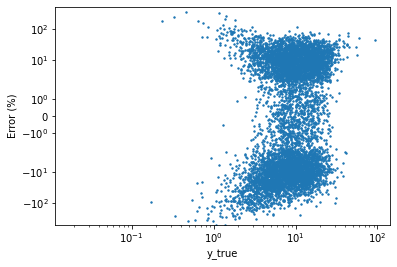

,Pre_Covid_Feature_Importance
Travel Time to Work_10 to 14 minutes,9.225441
STATE,7.433890
weekday,6.512596
Travel Time to Work_5 to 9 minutes,3.787807
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,3.464617
Median Household Income in the Past 12 Months (in 2018 Inflation-Adjusted Dollars)_Median household income in the past 12 months (in 2018 inflation-adjusted dollars),3.211240
mintempC,2.457168
Travel Time to Work_15 to 19 minutes,1.974906
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,1.945917
Race_Black or African American alone,1.857217


In [49]:
df_mob_train_pre = df_mob_train[df_mob_train.date < '2020-03-15']
df_mob_train_pre = df_mob_train_pre[df_mob_train_pre.m50<100]
df_mob_pre_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_pre,name = 'Pre', task_type='CPU',max_depth = 6)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

Total Rows Test Dataset 7337 ||| Records with over 200% error 50


,error_pct,Count
STATE,,
Alaska,-15.022138,3
Vermont,-11.138050,29
Nevada,-9.314362,29
New Hampshire,-5.206779,29
Idaho,-4.633654,87
Connecticut,-3.408073,25
Montana,-2.843948,55
Colorado,-2.087394,128
Kansas,-2.028866,150


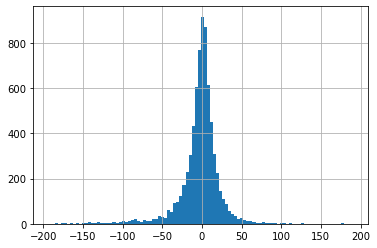

In [50]:
pd.options.mode.chained_assignment = None
y_test['pred']= y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_pre.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')

0:	learn: 4.8157223	total: 249ms	remaining: 4m 8s
200:	learn: 2.0330670	total: 44.2s	remaining: 2m 55s
400:	learn: 1.7927233	total: 1m 28s	remaining: 2m 12s
600:	learn: 1.6543077	total: 2m 13s	remaining: 1m 28s
800:	learn: 1.5543123	total: 2m 57s	remaining: 44.1s
999:	learn: 1.4753159	total: 3m 42s	remaining: 0us
0.85


c:\users\swami\anaconda3\envs\base_env\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


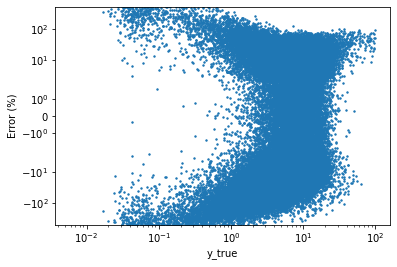

,Post_Covid_Feature_Importance
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,7.283262
weekday,5.294412
Travel Time to Work_10 to 14 minutes,5.054611
case_rate,4.328223
WindChillC,4.216340
STATE,4.150673
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,3.501980
Race_White alone,2.779978
Travel Time to Work_5 to 9 minutes,2.614442
Race_Asian alone,2.070163


In [51]:
df_mob_train_covid = df_mob_train[df_mob_train.date >= '2020-03-15']
df_mob_train_covid = df_mob_train_covid[df_mob_train_covid.m50<100]
df_mob_covid_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_covid,task_type='CPU',name='Post',max_depth = 8)
df_mob_covid_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

Total Rows Test Dataset 96061 ||| Records with over 200% error 3797


,error_pct,Count
STATE,,
Alabama,0.249212,2430
Alaska,0.727880,43
Arizona,-0.309606,535
Arkansas,0.366236,2485
California,0.050959,1995
Colorado,-1.779780,1508
Connecticut,3.347064,285
Delaware,-0.616763,102
Florida,0.286198,2719


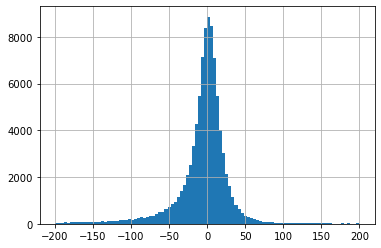

In [52]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_covid.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], axis=1)

In [53]:
county_dict = df_county_demo.set_index('fips')['COUNTY'].to_dict()
state_dict = df_county_demo.set_index('fips')['STATE'].to_dict()
def get_name(name_dict, x):
    
    if x in name_dict.keys():
        return name_dict[x]
    else:
        return None
df_mobility_rm['STATE'] = df_mobility_rm['fips'].apply(lambda x: get_name(state_dict, x))
df_mobility_rm['COUNTY'] = df_mobility_rm['fips'].apply(lambda x: get_name(county_dict, x))

# Mobility Reduction

In [54]:
df_mob_rm_train = get_model_df(df_weather, df_mobility_rm,df_covid,df_county_demo)

In [55]:
# Creating a dataframe to record reduction in spending and mobility before and after covid
target_cols = ['rolling_mean_mob'] #,'spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
window = covid_date -datetime.timedelta(days=10)
df_covid = df_mob_rm_train[df_mob_rm_train.date>=window]
df_pre = df_mob_rm_train[(df_mob_rm_train.date<window)]
df_pre_mean = df_pre.groupby(['fips','date'])[target_cols].mean()

pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_covid.groupby(['fips','date'])[target_cols].mean()


post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = df_covid_mean.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_rolling_mean_mob']>=-0.5]
df_mob_spend_red.sample(5)

,fips,rolling_mean_mob,Min_rolling_mean_mob,min_date_rolling_mean_mob,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob
886,21073,7.637786,1.290143,2020-04-17,33,0.025184,0.831084
1740,39051,6.949643,1.672286,2020-04-01,17,0.044669,0.759371
600,17191,14.110036,3.511571,2020-03-28,13,0.057779,0.751130
2092,47119,11.708071,3.358143,2020-04-06,22,0.032417,0.713177
1862,40133,12.383357,4.803714,2020-04-08,24,0.025503,0.612083


In [57]:
def plot_metric(df, col,name):
    plt.figure(figsize=(10,8))
    plt.rcParams["patch.force_edgecolor"] = True

    df[col].hist(bins = 50)
    plt.xlabel(name, fontsize=16)
    plt.ylabel('Count', fontsize = 16)

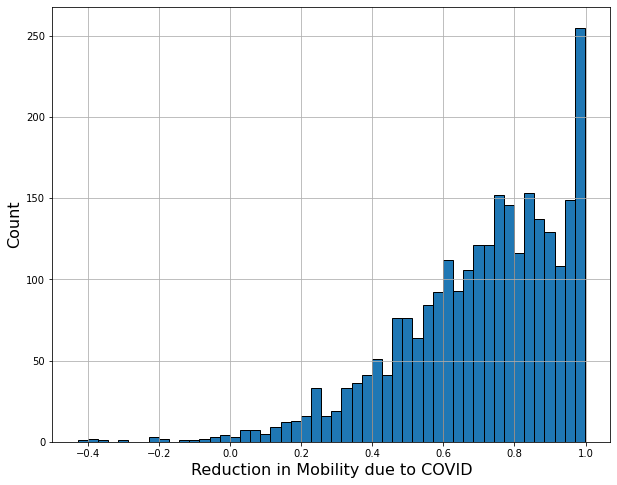

In [58]:
plot_metric(df_mob_spend_red,'Pct_Red_rolling_mean_mob','Reduction in Mobility due to COVID')

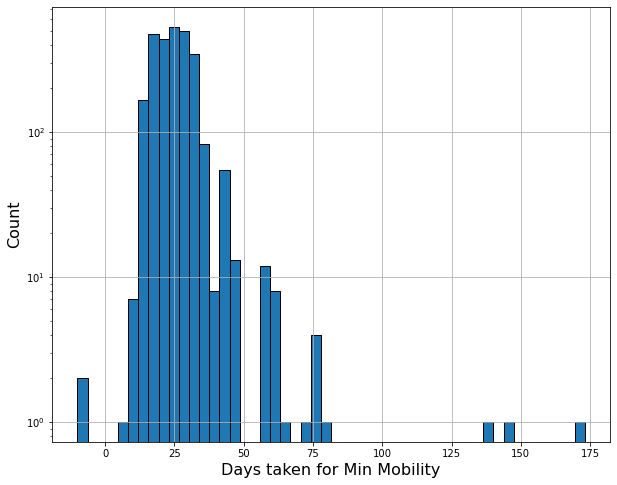

In [60]:
plot_metric(df_mob_spend_red,'Drop_days_rolling_mean_mob','Days taken for Min Mobility')
plt.yscale('log')

In [46]:
# df_merged = pd.merge(left = df_mobility, right = df_covid_growth, on= ['COUNTY', 'STATE'],how='left')
# df_merged['growthFactor'] = df_merged['growthFactor'].fillna(df_merged['growthFactor'].mean() )
# df_merged.corr()

In [47]:
df_mob_spend_red

,fips,rolling_mean_mob,Min_rolling_mean_mob,min_date_rolling_mean_mob,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob
0,01001,10.587000,4.551286,2020-04-10,26,0.021927,0.570106
1,01003,10.676143,4.432000,2020-04-12,28,0.020888,0.584869
2,01005,10.062929,4.576286,2020-04-17,33,0.016522,0.545233
3,01007,13.578786,8.262571,2020-04-12,28,0.013982,0.391509
4,01009,17.315821,9.241143,2020-04-12,28,0.016654,0.466318
...,...,...,...,...,...,...,...
2651,56033,4.187357,1.506571,2020-04-15,31,0.020652,0.640209
2652,56035,2.982571,0.464857,2020-04-06,22,0.038370,0.844142
2653,56037,7.743893,2.241571,2020-04-16,32,0.022204,0.710537
2654,56039,5.144964,0.656000,2020-04-06,22,0.039659,0.872497
